In [1]:
# !wget https://mb.dkn.tv/wp-content/uploads/2019/12/mb-0-0-sunset-photo-under-cco-700x366.jpg
!wget https://d25tv1xepz39hi.cloudfront.net/2017-08-21/files/landscape-photography_1645.jpg

--2020-12-11 06:08:25--  https://d25tv1xepz39hi.cloudfront.net/2017-08-21/files/landscape-photography_1645.jpg
Resolving d25tv1xepz39hi.cloudfront.net (d25tv1xepz39hi.cloudfront.net)... 54.240.168.217, 54.240.168.63, 54.240.168.123, ...
Connecting to d25tv1xepz39hi.cloudfront.net (d25tv1xepz39hi.cloudfront.net)|54.240.168.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166291 (162K) [image/jpeg]
Saving to: ‘landscape-photography_1645.jpg’

landscape-photograp 100%[===================>] 162.39K   325KB/s    in 0.5s    

2020-12-11 06:08:27 (325 KB/s) - ‘landscape-photography_1645.jpg’ saved [166291/166291]



In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
def sobel_kernel(dx=None,dy=None):
  if dx:
    ret = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
  if dy:
    ret = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
  return ret

In [5]:
img = cv2.imread('image1.jpg', 0)
HEIGHT, WIDTH = img.shape
# img = cv2.cvtColor(img, cv)
print(img.shape)

(683, 1024)


In [6]:
gaused = convolve2d(img, gaussian_kernel(5, 1), mode='same')

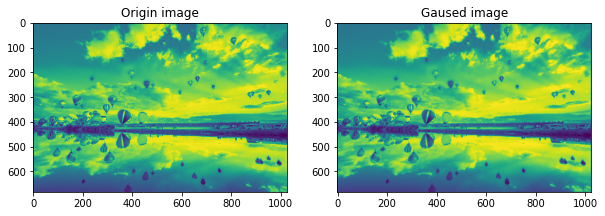

In [7]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,10)
ax[0].imshow(img)
ax[0].set_title('Origin image')
ax[1].imshow(gaused)
ax[1].set_title('Gaused image')
plt.show()

In [8]:
sobel_x = sobel_kernel(dx=1)
sobel_y = sobel_kernel(dy=1)

In [9]:
gradient_x = convolve2d(gaused, sobel_x, mode='same')
gradient_y = convolve2d(gaused, sobel_y, mode='same')

gradient_magnitude = np.hypot(gradient_x, gradient_y)
gradient_magnitude = gradient_magnitude / np.max(gradient_magnitude) * 255

theta = np.arctan(gradient_y / gradient_x)
theta_in_degree = theta / np.pi * 180

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


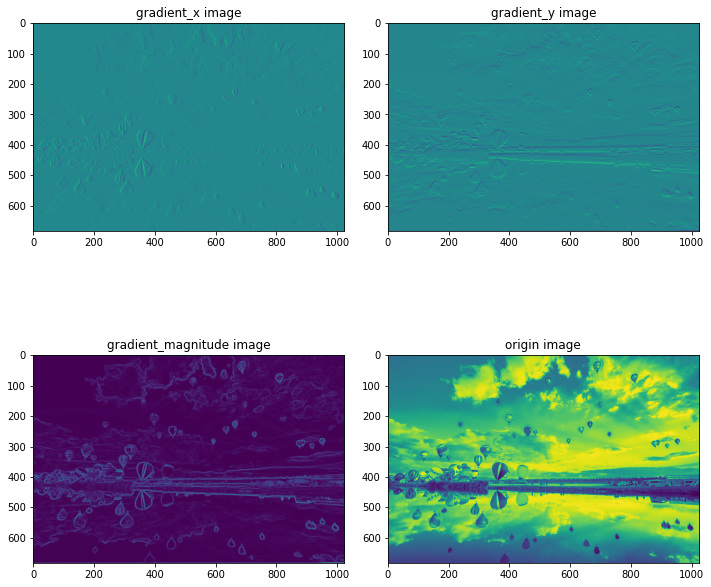

In [10]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,10)
ax[0,0].imshow(gradient_x)
ax[0,0].set_title('gradient_x image')
ax[0,1].imshow(gradient_y)
ax[0,1].set_title('gradient_y image')


ax[1,0].imshow(gradient_magnitude)
ax[1,0].set_title('gradient_magnitude image')
ax[1,1].imshow(img)
ax[1,1].set_title('origin image')
fig.tight_layout()
plt.show()

In [11]:
np.where(gradient_magnitude > 100)[0].shape

(2960,)

In [12]:
def get_mask(degree):
  mask = np.zeros((3,3))
  #equal to +- 90
  if np.abs(degree) >= 67.5:
    mask[(0,2), 1] = 1
  # equal to -45:
  elif -67.5 <= degree <= -22.5:
    mask[(0,2), (0,2)] = 1
  #equal to 0:
  elif np.abs(degree) <= 22.5:
    mask[1, (0,2)] = 1
  # equal to 45
  elif 22.5 <= degree <= 67.5:
    mask[(0,2), (2,0)] = 1
  return mask

In [13]:
temp = np.zeros_like(img)
for r in range(1, HEIGHT - 1):
  for c in range(1, WIDTH - 1):
    mask = get_mask(theta_in_degree[r,c])
    if np.max(gradient_magnitude[(r-1):(r+2),(c-1):(c+2)]*mask) - gradient_magnitude[r,c] < 0.5:
      temp[r,c] = gradient_magnitude[r,c]

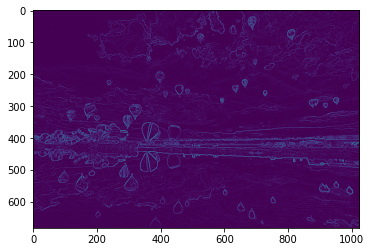

In [14]:
plt.imshow(temp)
plt.show()

In [15]:
high_threshold = 40
low_threshold = 20

weak_intentsity = 150
strong_intensity = 200

In [16]:
gnh = temp.copy()
gnl = temp.copy()

In [17]:
gnh[temp < high_threshold] = 0
gnh[gnh>1] = strong_intensity

gnl[temp >= high_threshold] = 0
gnl[temp < low_threshold] = 0
gnl[gnl>0] = weak_intentsity

In [18]:
pos = np.where(gnh > 0)
points = zip(pos[0], pos[1])
for point in points:
  if point[0] == 0 or point[0] == WIDTH - 1:
    continue
  if point[1] == 0 or point[1] == HEIGHT - 1:
    continue
  ids = np.array(np.where(gnl[point[0]-1:point[0]+2, point[1] - 1:point[1] + 2] > 0))
  gnh[point[0]- 1 + ids[0], point[1] - 1 + ids[1]] = strong_intensity
  

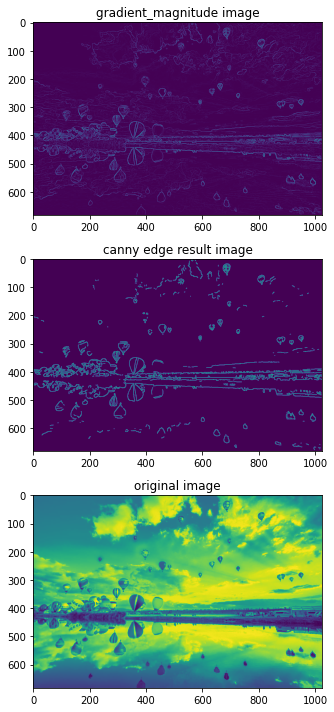

In [19]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10,10)
ax[0].imshow(temp)
ax[0].set_title('gradient_magnitude image')
ax[1].imshow(gnh)
ax[1].set_title('canny edge result image')
ax[2].imshow(img)
ax[2].set_title('original image')
fig.tight_layout()
plt.show()

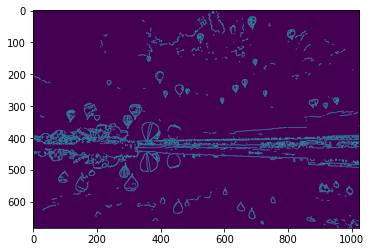

In [20]:
plt.imshow(cv2.Canny(img, 250, 200, ))